http://archive.ics.uci.edu/ml/datasets/thyroid+disease [[Page](https://www.openml.org/d/57)] [[CSV](https://www.openml.org/data/get_csv/57/dataset_57_hypothyroid.arff)]
Target – Class

Scoring (10 max):
* EDA: exploration of variables and properties of data with conclusions - 1
* Data preprocessing if needed - 2
    * Handling missing values
    * Dropping unimportant features
    * Data normalization
    * Categorical encoding
* [Scikit pipeline](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) usage – 2
* Metrics and cross-validation chosen as well as reasoning behind – 1
* Different techniques for handling imbalance data (over\under sampling, class weight) - 2
* Feature engineering e.g. [transformations](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) (nonlinear) - 1
* Feature importance and [hyperparameters](http://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers) tuning – 1

Models: Logistic Regression w\wo regularization; K-nearest neighbors

***

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Заглянем в файл, увидим, что missing values кодируются символом вопроса "?", boolean features кодируются символами "f", "t"

In [2]:
df = pd.read_csv('dataset_57_hypothyroid.csv', na_values='?', true_values='t', false_values='f')
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,NaN,SVHC,negative
1,23.0,F,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,NaN,other,negative
2,46.0,M,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,NaN,other,negative
3,70.0,F,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,NaN,other,negative
4,70.0,F,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,NaN,SVI,negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3771 non-null float64
sex                          3622 non-null object
on_thyroxine                 3772 non-null bool
query_on_thyroxine           3772 non-null bool
on_antithyroid_medication    3772 non-null bool
sick                         3772 non-null bool
pregnant                     3772 non-null bool
thyroid_surgery              3772 non-null bool
I131_treatment               3772 non-null bool
query_hypothyroid            3772 non-null bool
query_hyperthyroid           3772 non-null bool
lithium                      3772 non-null bool
goitre                       3772 non-null bool
tumor                        3772 non-null bool
hypopituitary                3772 non-null bool
psych                        3772 non-null bool
TSH_measured                 3772 non-null bool
TSH                          3403 non-null float64
T3_measured          

In [4]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

* 'TBG' можно сразу выкинуть, ибо столбец пустой
* 20 boolean featuers, 6 (без 'TBG') числовых, 3 строковых
* есть missing values, их может быть и немного, но это еще ни о чем хорошем не говорит
* выборка очень-очень-очень несбалансирована. в выборке 3772 объекта, а один из target-классов представлен лишь 2(!) объектами, и что с этим делать – не ясно

In [5]:
if 'TBG' in df:
    df = df.drop(columns=['TBG'])

Посмотрим на гистограммы категориальных признаков

In [6]:
cat_features = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source']

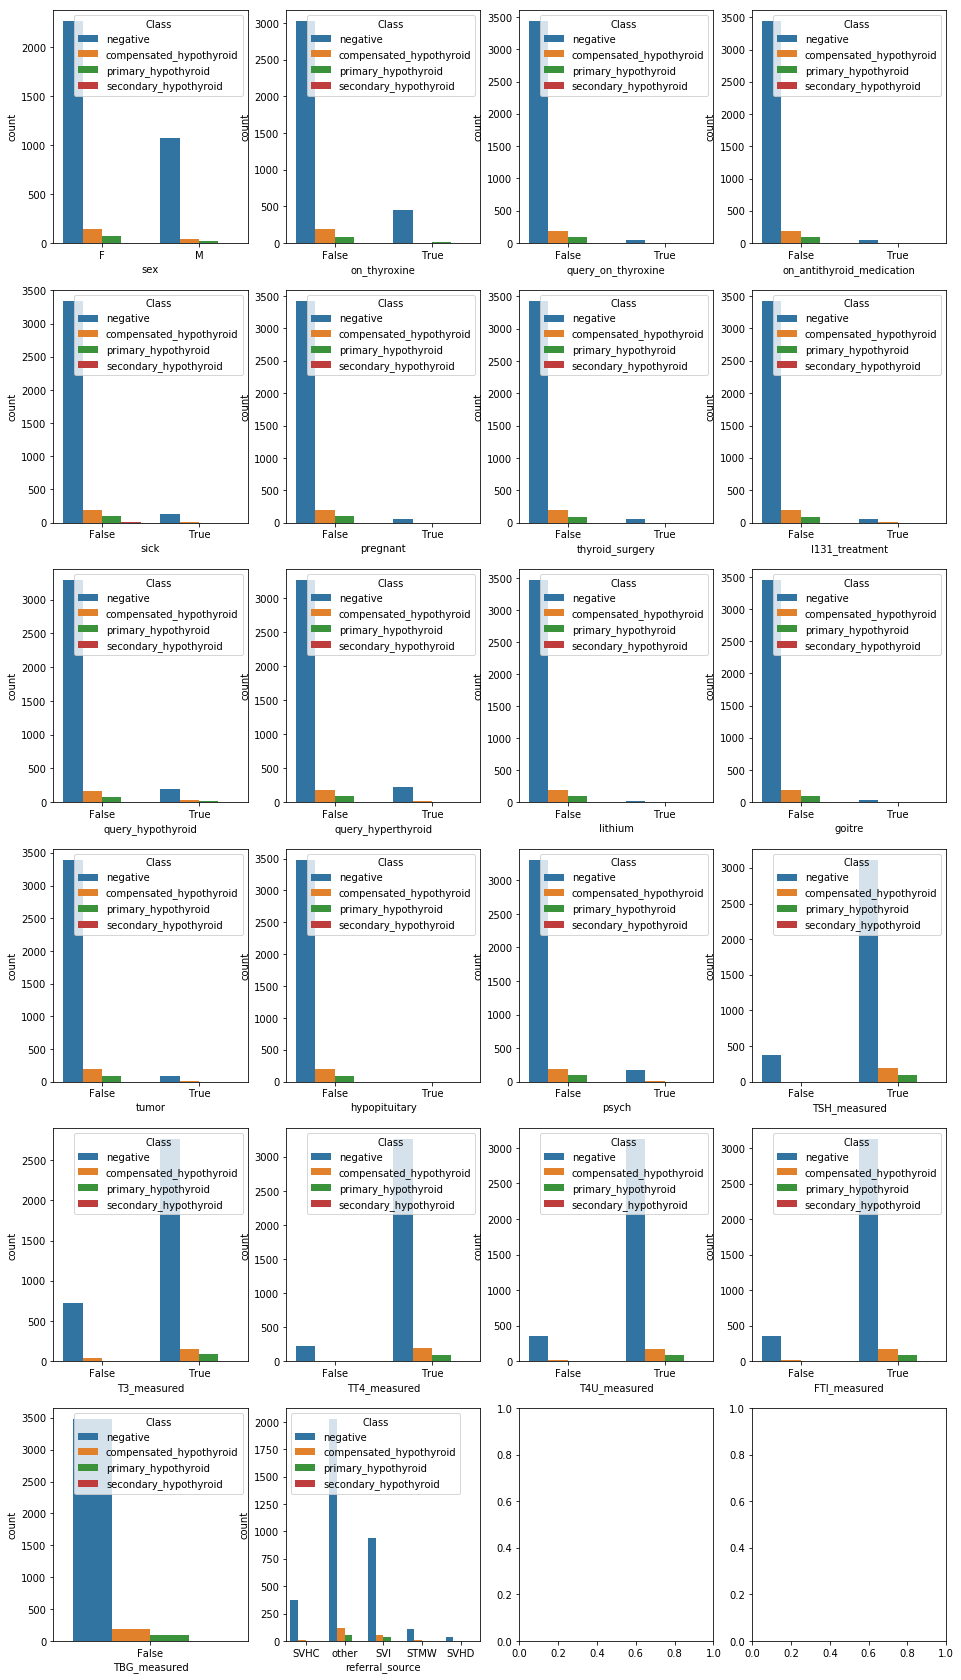

In [7]:
f, axes = plt.subplots(nrows=6, ncols=4, figsize=(16, 30))
for index, col_name in enumerate(cat_features):
    sns.countplot(x=col_name, hue='Class', data=df, ax=axes[index//4, index%4]);

* 'TBG_measured' также бесполезный признак, поскольку имеет всегда одно значение False и missing values в нем нет. поэтому выбросим его. можно, наверное, было сразу догадаться, что так будет, посмотрев на названия столбцов – если в 'TGB' ничего нет, значит этот параметр у больных не измерялся, соответственно 'TGB_**measured**' всегда должно быть False
* сказать, что по каким-то из этих признаков один из классов хорошо отделяется, я не могу
* наглядное подтверждение тому, что выборка несбалансирована

Посмотрим на гистограммы без класса Class='negative'

In [8]:
if 'TBG_measured' in df:
    df = df.drop(columns=['TBG_measured'])
cat_features = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'referral_source']

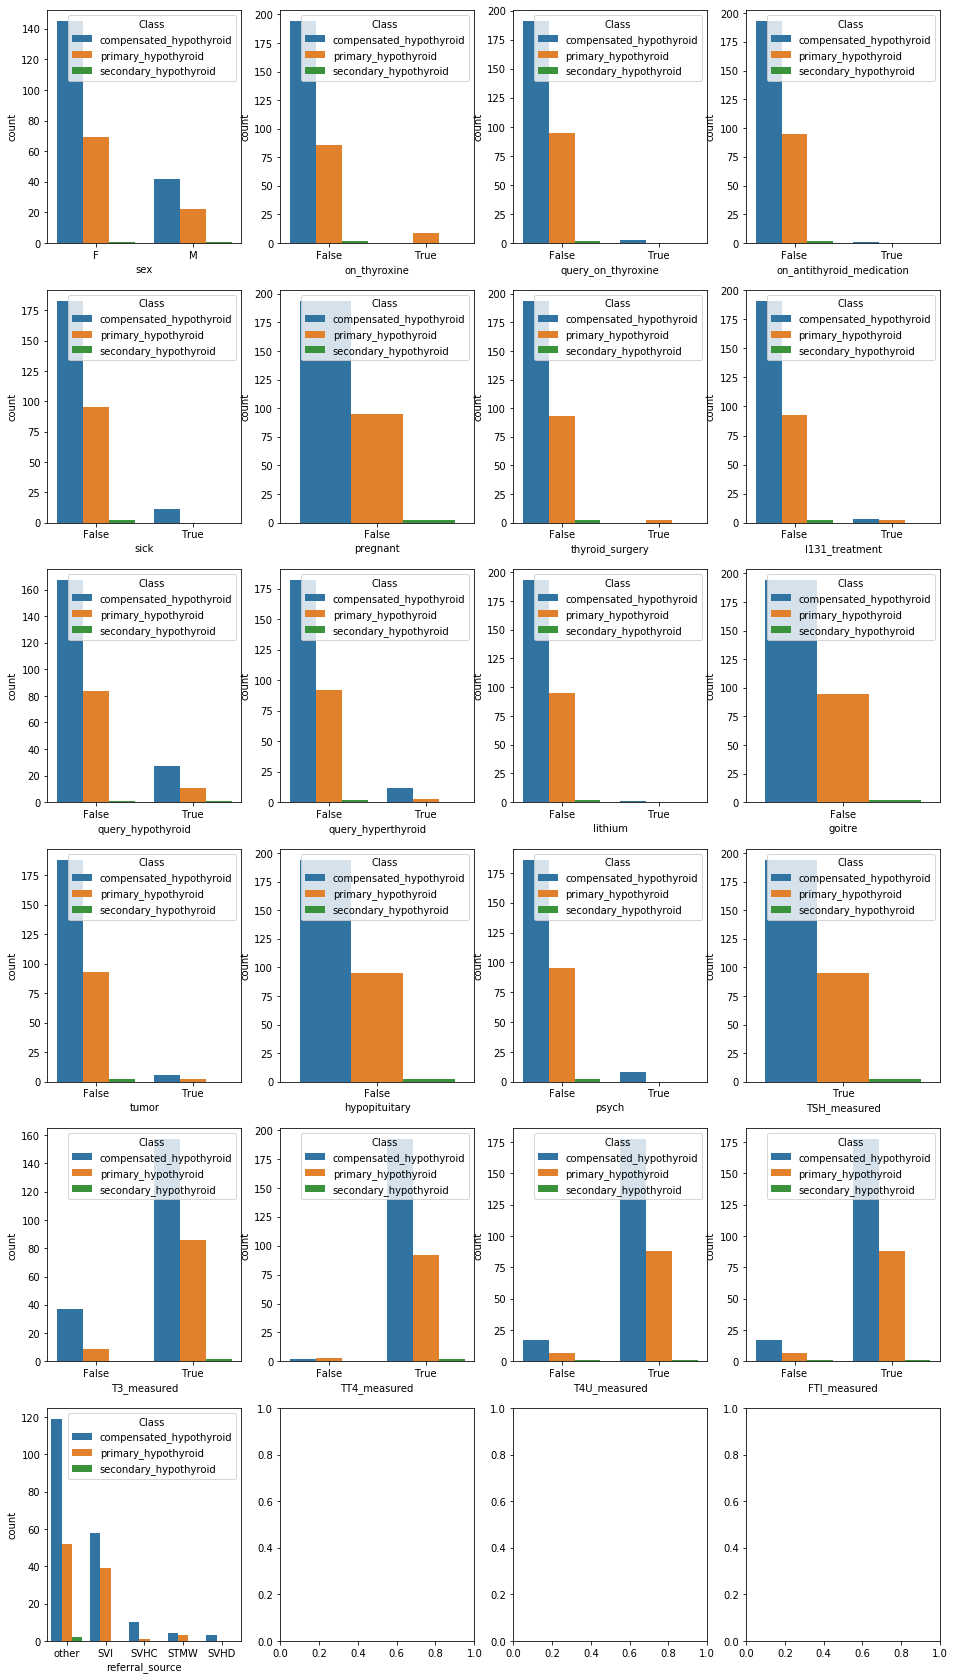

In [9]:
df_pos = df[df['Class'] != 'negative']
f, axes = plt.subplots(nrows=6, ncols=4, figsize=(16, 30))
for index, col_name in enumerate(['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'referral_source']):
    sns.countplot(x=col_name, hue='Class', data=df_pos, ax=axes[index//4, index%4]);

* у положительных (т.е. у больных людей) трех классов некоторые признаки имеют лишь одно значение
* если смотреть на эту подвыборку отдельно, то можно отметить, что и она плохо сбалансирована
* в целом, смотря на эти графики, нельзя сказать, что в данных есть какая-нибудь очевидная структура, которая могла бы помочь в классификации

Посмотрим на распределения вещественных переменных

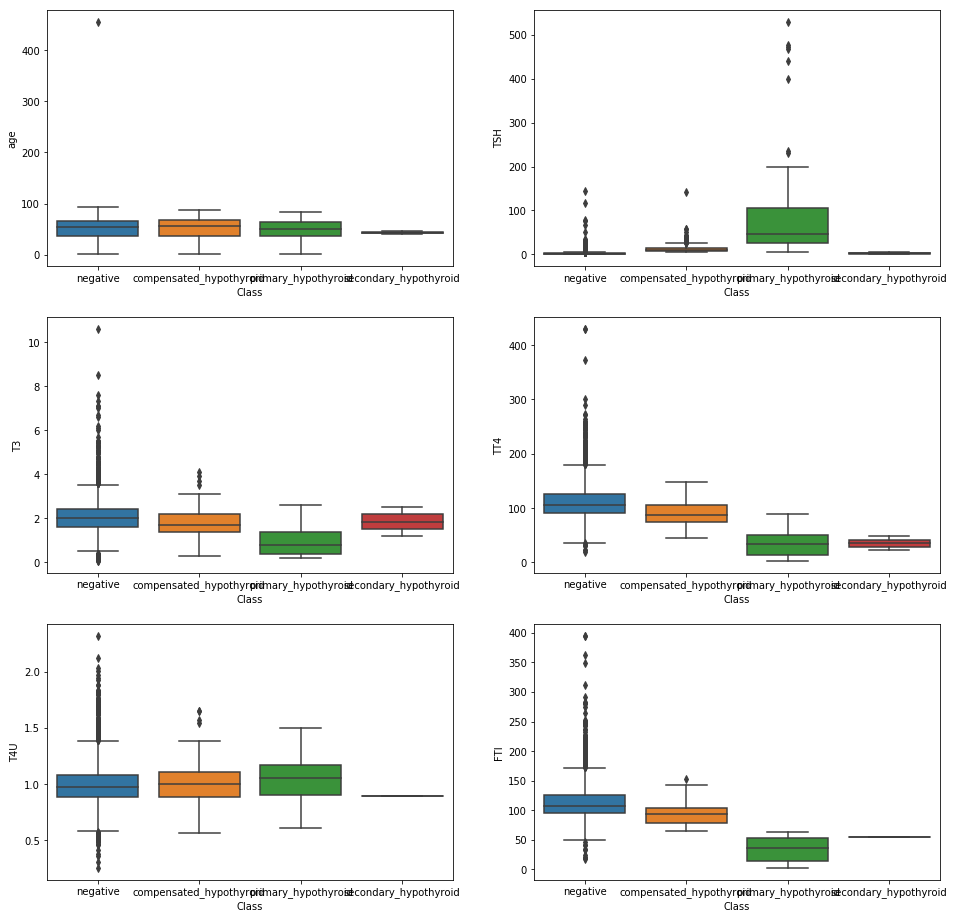

In [10]:
real_features = ['age','TSH','T3','TT4','T4U','FTI']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
for index, col_name in enumerate(real_features):
#     plt.hist(df[col_name].values)
    sns.boxplot(x='Class', y=col_name, data=df, ax=axes[index//2, index%2])

и без Class='negative'

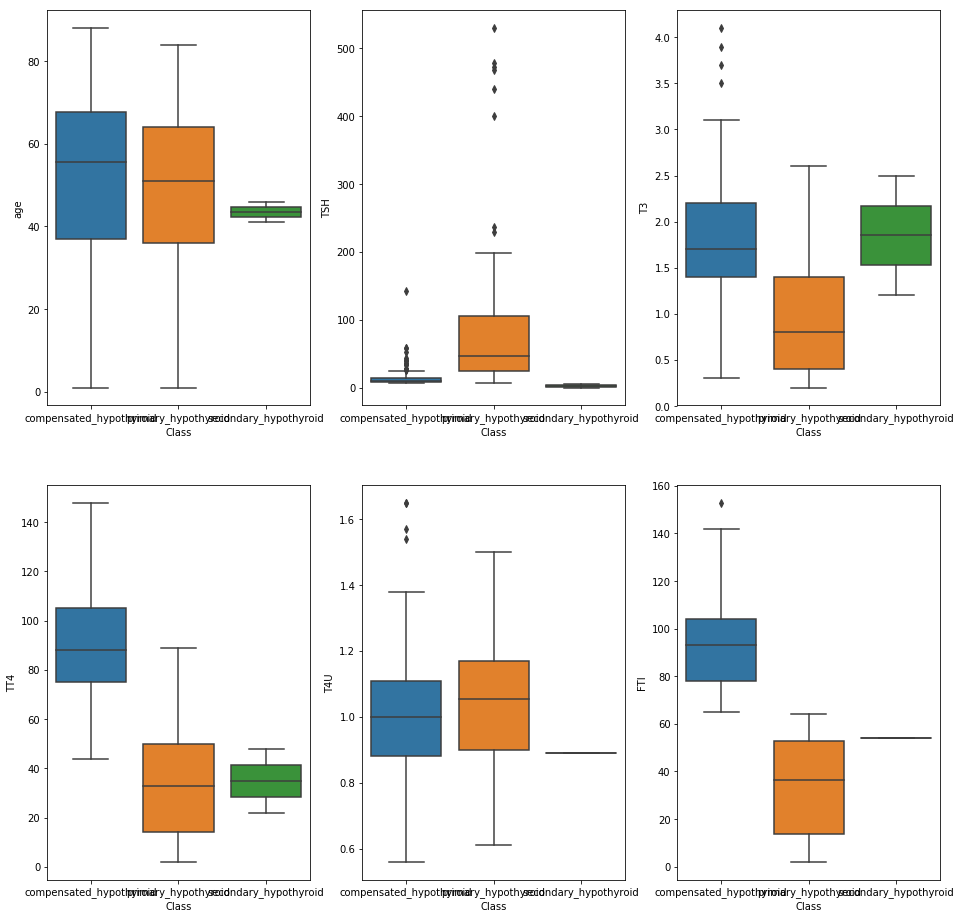

In [11]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 16))
for index, col_name in enumerate(real_features):
    sns.boxplot(x='Class', y=col_name, data=df_pos, ax=axes[index//3, index%3])

* на картине в целом можно увидеть некоторое (большое или нет по картинкам судить сложно) количество outliers
* большинство outliers принадлежат классу negative, что радует, потому что в этом классе объектов гораздо больше, чем в остальных, и поэтому объекты с выбросами можно будет безболезненно (но это не точно) удалить
* если смотреть на картину "положительных" (т.е. людей с той или иной формой болезни, не Class='negative'), то можно увидеть, что классы primary и secondary визуально отделяются по признакам FTI и TSH. проверим эту гипотезу
* можно предположить, что вещественные признаки будут иметь бОльшую значимость при классификации, чем категориальные, особенно если сначала отделить класс negative

Итак, сначала проверим гипотезу

In [12]:
df_pos.groupby(['Class'])['TSH'].aggregate(['min', 'max'])

,min,max
Class,,
compensated_hypothyroid,6.100,143.0
primary_hypothyroid,6.200,530.0
secondary_hypothyroid,0.015,4.6


Да, действительно, класс secondary с двумя объектами можно отделить от других двух положительных лишь по одному признаку TSH, причем это "правило" является вполне хорошим, потому что больше данных у нас нет, и, возможно, какое-нибудь решающее дерево именно так и сделало бы

In [13]:
df_pos.groupby(['Class'])['FTI'].aggregate(['min', 'max'])

,min,max
Class,,
compensated_hypothyroid,65.0,153.0
primary_hypothyroid,2.0,64.0
secondary_hypothyroid,54.0,54.0


Да, аналогично получается отделить primary от compensated по признаку FTI

Посмотрим внимательнее на outliers на графиках и подумаем, какие объекты можно выкинуть

In [14]:
df_neg = df[df['Class'] == 'negative']

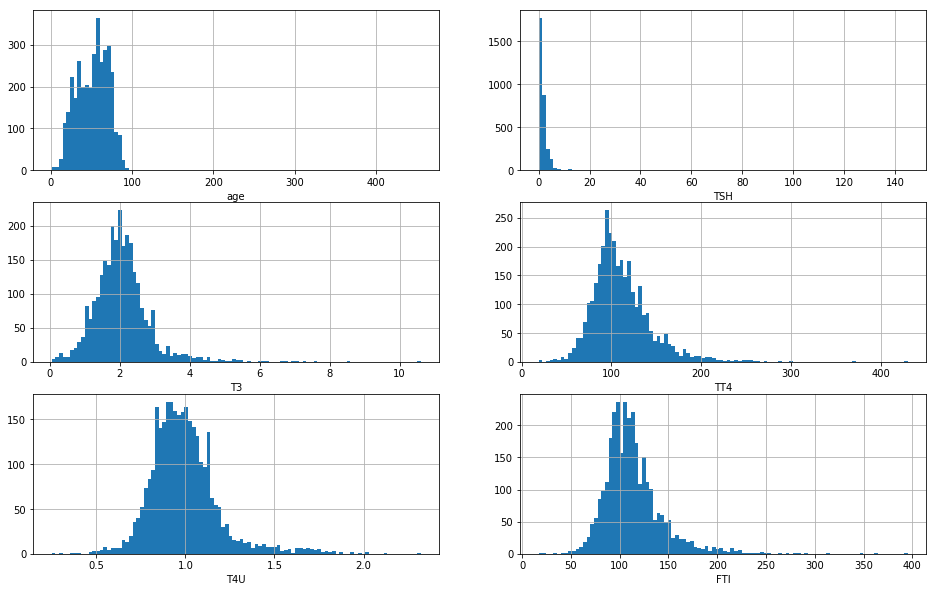

In [15]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
# df[real_features].plot(subplots=True, kind='hist', layout=(3, 2), figsize=(16,10), sharex=False, bins=25)
for index, col_name in enumerate(real_features):
    ax = axes[index//2, index%2]
    df_neg[col_name].hist(ax=ax, bins=100)
    ax.set_xlabel(col_name)

Выкинем строки из index (см. cell). Значения подбирались глядением на boxplotы и гистограммы.

In [16]:
index = df[(df['Class'] == 'negative') &
           ((df['age'] > 200) |
            (df['TSH'] > 6.2) |
            (df['T3'] > 4.5) |
            (df['TT4'] > 225) |
            (df['T4U'] > 1.75) |
            (df['FTI'] > 230))].index
df_wo = df.drop(axis=0, index=index)
len(index)

151

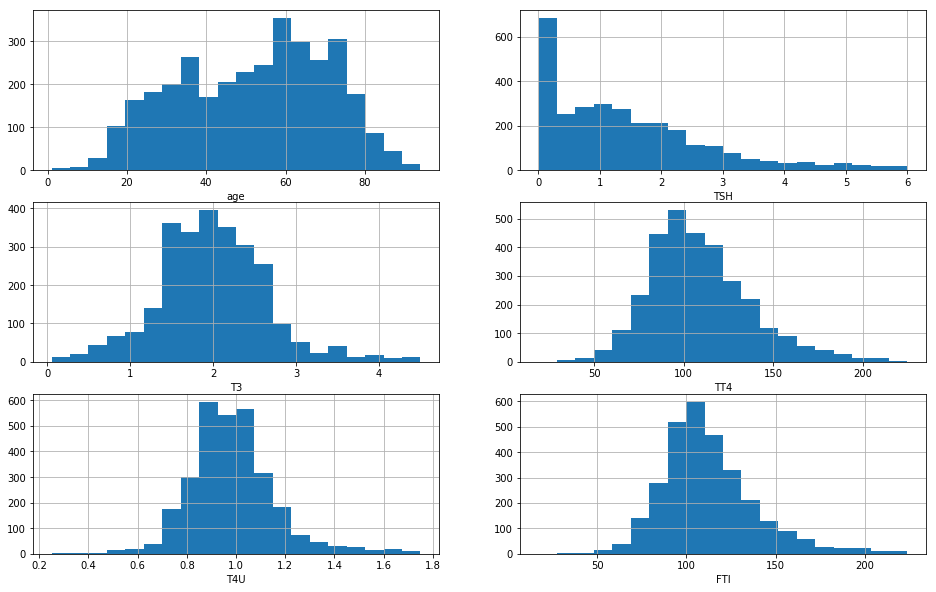

In [17]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
for index, col_name in enumerate(real_features):
    ax = axes[index//2, index%2]
    df_wo[df_wo['Class'] == 'negative'][col_name].hist(ax=ax, bins=20)
    ax.set_xlabel(col_name)

Стало значительно лучше. Аналогично поступим с положительными классами. Но тут важно выкинуть только совсем outlierы, потому что объектов и так мало

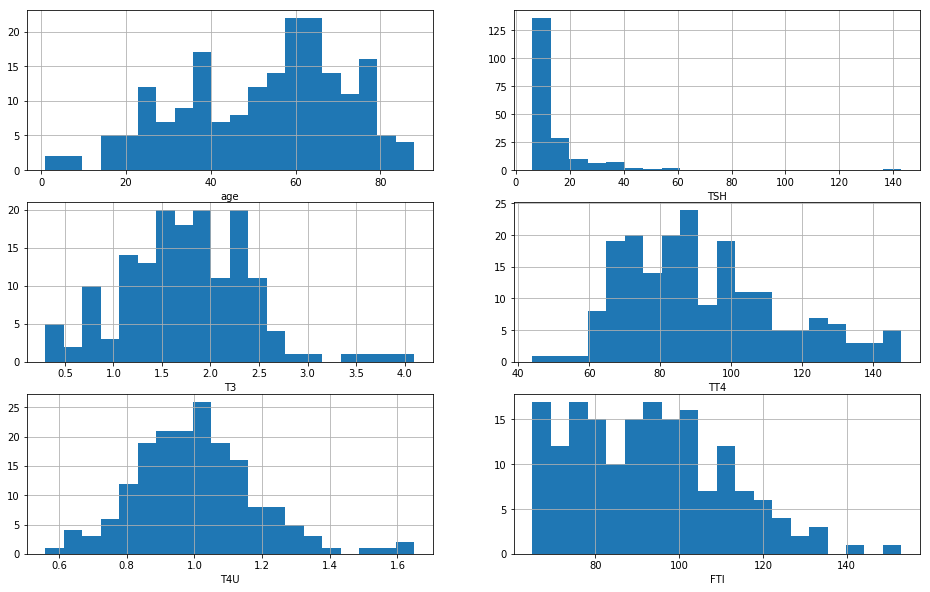

In [18]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
for index, col_name in enumerate(real_features):
    ax = axes[index//2, index%2]
    df_wo[df_wo['Class'] == 'compensated_hypothyroid'][col_name].hist(ax=ax, bins=20)
    ax.set_xlabel(col_name)

In [19]:
index = df_wo[(df_wo['Class'] == 'compensated_hypothyroid') &
               ((df_wo['T3'] > 3.3) |
                (df_wo['T4U'] > 1.45) |
                (df_wo['FTI'] > 145) |
                (df_wo['TSH'] > 100))].index
df_wo = df_wo.drop(axis=0, index=index)
len(index)

8

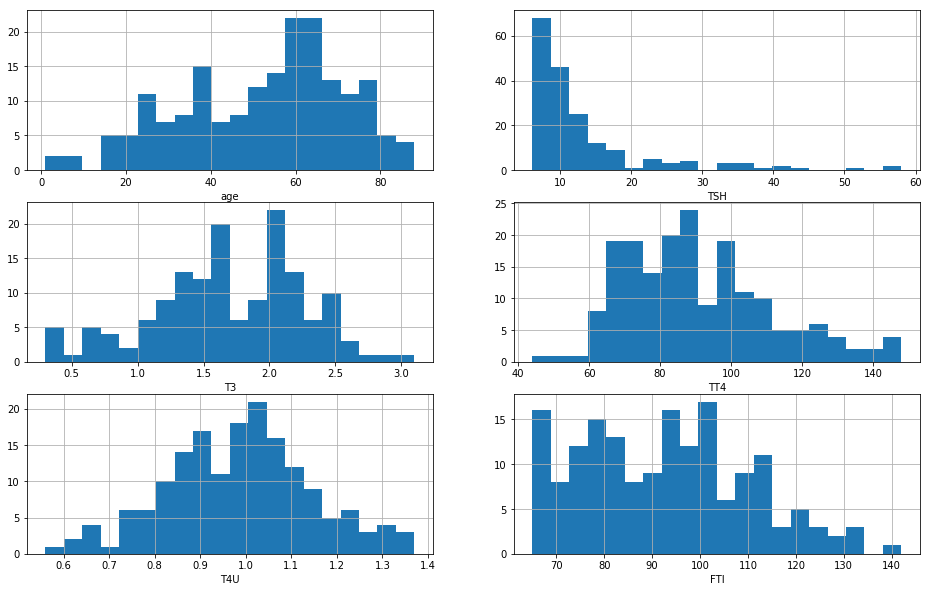

In [20]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
for index, col_name in enumerate(real_features):
    ax = axes[index//2, index%2]
    df_wo[df_wo['Class'] == 'compensated_hypothyroid'][col_name].hist(ax=ax, bins=20)
    ax.set_xlabel(col_name)

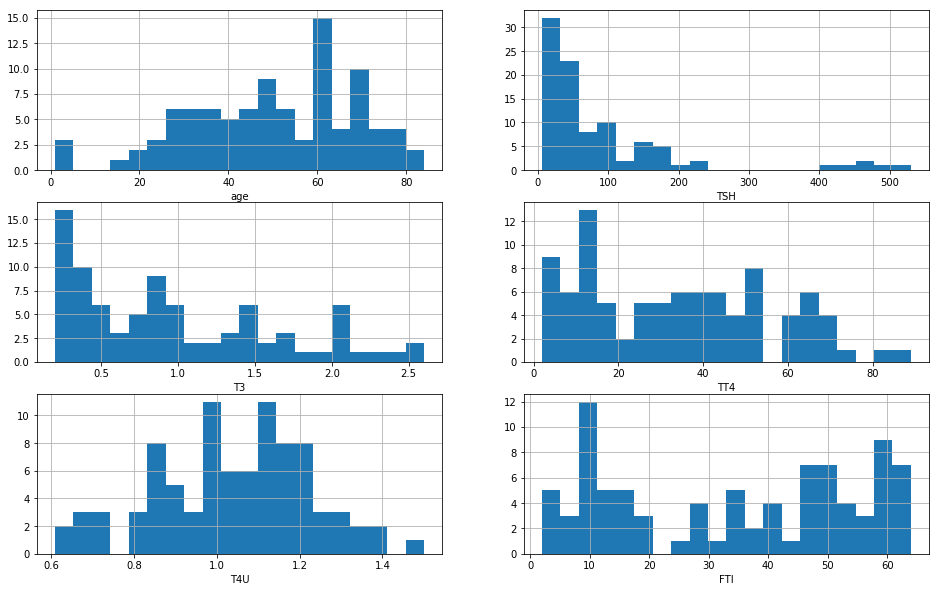

In [21]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
for index, col_name in enumerate(real_features):
    ax = axes[index//2, index%2]
    df_wo[df_wo['Class'] == 'primary_hypothyroid'][col_name].hist(ax=ax, bins=20)
    ax.set_xlabel(col_name)

In [22]:
index = df_wo[(df_wo['Class'] == 'primary_hypothyroid') &
                       (df_wo['TSH'] > 210)].index
df_wo = df_wo.drop(axis=0, index=index)
len(index)

8

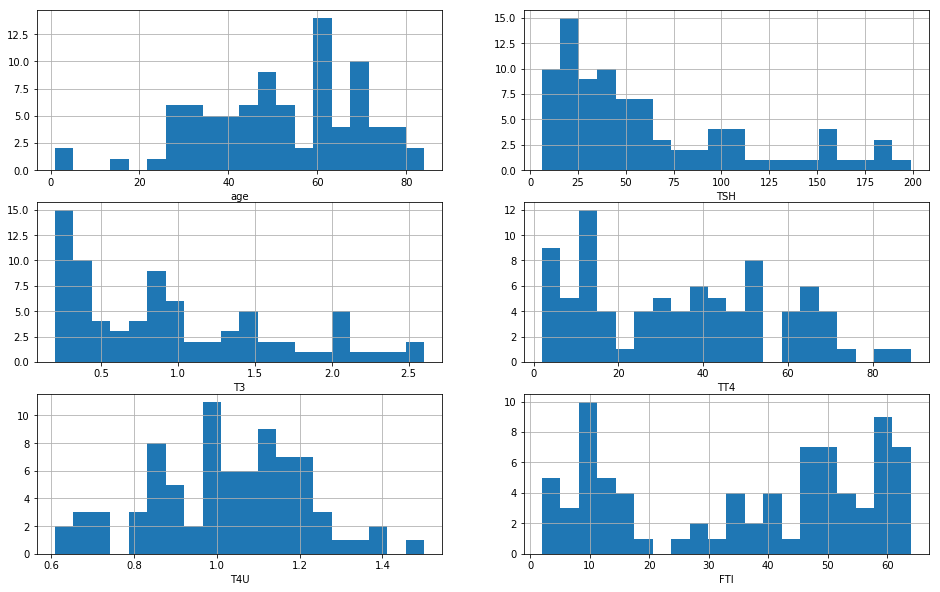

In [23]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
for index, col_name in enumerate(real_features):
    ax = axes[index//2, index%2]
    df_wo[df_wo['Class'] == 'primary_hypothyroid'][col_name].hist(ax=ax, bins=20)
    ax.set_xlabel(col_name)

Итого из класса negative ушел 151 объект, из compensated и primary по 8. Из secondary по очевидным причинам 0

Теперь посмотрим на пропуски и ~~продолжим выкидывать объекты~~ подумаем, что с ними делать

In [24]:
df_nulls = df_wo[df_wo.isnull().any(axis=1)]

In [25]:
df_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 1 to 3767
Data columns (total 28 columns):
age                          1084 non-null float64
sex                          942 non-null object
on_thyroxine                 1085 non-null bool
query_on_thyroxine           1085 non-null bool
on_antithyroid_medication    1085 non-null bool
sick                         1085 non-null bool
pregnant                     1085 non-null bool
thyroid_surgery              1085 non-null bool
I131_treatment               1085 non-null bool
query_hypothyroid            1085 non-null bool
query_hyperthyroid           1085 non-null bool
lithium                      1085 non-null bool
goitre                       1085 non-null bool
tumor                        1085 non-null bool
hypopituitary                1085 non-null bool
psych                        1085 non-null bool
TSH_measured                 1085 non-null bool
TSH                          721 non-null float64
T3_measured            

In [26]:
df_nulls['Class'].value_counts()

negative                   1012
compensated_hypothyroid      58
primary_hypothyroid          14
secondary_hypothyroid         1
Name: Class, dtype: int64

1085 строк с хотя бы одним пропущенным значением. Причем пропуски только в sex и вещественных признаках. Ну, я думаю, можно (не очень смело, но все же) выкинуть все, что относится к классу negative – от этого задача станет только сбалансированнее

In [27]:
df_wo = df_wo.drop(axis=0, index=df_nulls[df_nulls['Class'] == 'negative'].index)
df_nulls = df_wo[df_wo.isnull().any(axis=1)]

Теперь будем разбираться с положительными классами. Посмотрим что пропущено в объекте класса secondary – лишь T4U и FTI, только вещественные признаки. Для вещественных признаков есть очевидные способы заполнения пропусков (среднее/медиана по таргет-классу). Так и сделаем, заполним пропуски медианой по признаку в данном классе. Для одного объекта класса secondary этого будет замена их на значения из другого объекта этого класса

In [28]:
for cls in df_wo[df_wo['Class'] != 'negative']['Class'].unique():
    df_temp = df_wo[df_wo['Class'] == cls]
    df_wo.loc[df_temp.index] = df_wo.loc[df_temp.index].fillna(df_temp.median())

Что делать с категориальным sex не очень ясно. Попробуем следующее: найдем три (в общем случае несколько) объекта, наиболее близких к данному по признакам, в которых нет пропусков, и заполним пропуски средними по найденным трем объектами. По сути мы решаем две (для классов primary и secondary) kNN задачи классификации

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [30]:
temp = df_wo[(df_wo['Class'] == 'primary_hypothyroid')]
temp['referral_source'] = LabelEncoder().fit_transform(temp['referral_source'])
X_train = temp[temp['sex'].notnull()].drop(columns=['sex', 'Class'])
y_train = temp[temp['sex'].notnull()]['sex']
X_test = temp[temp['sex'].isnull()].drop(columns=['sex', 'Class'])

clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
df_wo.loc[X_test.index, 'sex'] = clf.predict(X_test)
df_wo.loc[X_test.index]

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
671,74.0,F,False,False,False,False,False,False,False,False,...,True,1.2,True,71.0,True,1.11,True,64.0,SVI,primary_hypothyroid
2103,68.0,F,False,False,False,False,False,False,False,False,...,True,0.3,True,6.0,True,0.80,True,7.6,other,primary_hypothyroid
2551,1.0,F,False,False,False,False,False,False,False,False,...,False,0.8,False,34.0,False,1.04,False,41.0,STMW,primary_hypothyroid


In [31]:
temp = df_wo[(df_wo['Class'] == 'compensated_hypothyroid')]
temp['referral_source'] = LabelEncoder().fit_transform(temp['referral_source'])
X_train = temp[temp['sex'].notnull()].drop(columns=['sex', 'Class'])
y_train = temp[temp['sex'].notnull()]['sex']
X_test = temp[temp['sex'].isnull()].drop(columns=['sex', 'Class'])

clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
df_wo.loc[X_test.index, 'sex'] = clf.predict(X_test)
df_wo.loc[X_test.index]

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
85,34.0,F,False,False,False,False,False,False,False,False,...,True,2.0,True,95.0,True,0.99,True,96.0,STMW,compensated_hypothyroid
115,1.0,M,False,False,False,False,False,False,False,False,...,True,1.9,True,113.0,True,0.86,True,131.0,STMW,compensated_hypothyroid
400,35.0,F,False,False,False,False,False,False,False,False,...,True,2.5,False,87.0,False,0.99,False,93.0,other,compensated_hypothyroid
2169,63.0,F,False,False,False,False,False,False,False,False,...,True,1.9,True,89.0,True,1.04,True,85.0,SVI,compensated_hypothyroid
2662,83.0,F,False,False,False,False,False,False,False,False,...,False,1.7,True,148.0,True,1.11,True,134.0,other,compensated_hypothyroid
2899,40.0,F,False,False,False,False,False,False,False,False,...,True,1.7,True,78.0,True,0.90,True,87.0,other,compensated_hypothyroid
3426,65.0,F,False,False,False,False,False,False,False,False,...,True,2.0,True,78.0,False,0.99,False,93.0,other,compensated_hypothyroid


Теперь у нас нет пропусков, и можно уже пытаться применять модели. Не уверен, что он понадобится, но создадим столбец BinClass, 0 - для класса negative, 1 - для положительных, и посмотрим, что получится с бинарной классификацией. В качестве метрики будем использовать f1, объединяющую precision и recall (возиться с prc уже нет времени), т.к. roc на подобных датасетах дает неадекватную действительности оценку. В интернетах в таких случаях еще рекомендуют использовать метрику [kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa). Потом обязательно про нее почитаю. В качестве стратегии кросс-валидации нужно использоваться StratifiedKFold. В документации к cross_val_score (и cross_validate) написано, что функция использует StratifiedKFold по умолчанию при классификации, но будем использовать явно. Будем использовать cross_validate вместо cross_val_score, чтобы получить score по нескольким метрикам сразу

In [32]:
df_wo['BinClass'] = np.where(df_wo['Class'] == 'negative', 0, 1)

In [139]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [34]:
df_wo['sex'].replace({'F': 1, 'M': 0}, inplace=True)

In [35]:
df_wo['referral_source'] = LabelEncoder().fit_transform(df_wo['referral_source'])

Не забудем нормализовать данные

In [151]:
df_wo[real_features] = StandardScaler().fit_transform(df_wo[real_features])

In [197]:
X = df_wo.drop(columns=['Class', 'BinClass'])
y = df_wo['BinClass']

In [200]:
score = cross_validate(estimator=LogisticRegression(class_weight='balanced'),
                X=X,
                y=y,
                cv=StratifiedKFold(n_splits=10, shuffle=True),
                scoring=['precision', 'recall', 'f1'],
                return_train_score=True)
[np.mean(score['train_precision']), np.mean(score['train_recall']), np.mean(score['train_f1'])]

[0.9042438918665019, 0.9991902834008097, 0.949336918805604]

In [201]:
[np.mean(score['test_precision']), np.mean(score['test_recall']), np.mean(score['test_f1'])]

[0.8951463560334527, 0.9853174603174605, 0.9377023570680711]

Очень хорошие оценки. Качестве на train лучше не на порядки, т.е. при всем этом модель не переобучилась. Попробуем оптимизировать параметр регуляризации (l2) через LogisticRegressionCV (пробовал и l1, результат хуже)

In [211]:
X = df_wo.drop(columns=['Class', 'BinClass'])
y = df_wo['BinClass']
clf = LogisticRegressionCV(Cs=20, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='f1', class_weight='balanced').fit(X, y)

In [212]:
clf.scores_[1].mean(axis=0).max(), clf.C_

(0.9612142021363675, array([10000.]))

Удалость еще сильнее поднять f1 (хотя при этом коэффициент регуляризации (он обратен C_) довольно таки мал). Оценки precision и recall можно было бы найти, используя GridSearchCV, но не будем этого делать, просто понимая, что они больше, чем на модели без регуляризации; достаточно понимать, что полученная модель (если она адекватна, в чем у меня есть сомнения) правильно классифицирует больше 90% объектов положительного класса, при этом она неверно относит к положительному классу не более 1% объектов от этих 90%. Поскольку до этого были найдены простые правила, позволяющие 100% верно классифицировать положительные классы между собой, то можно сказать, что итоговая модель будет иметь полученное значение f1. На исходных данных эта оценка, конечно, была бы хуже.

Посмотрим на коэффициенты модели, чтобы, возможно, сделать заключения о важности параметров

In [213]:
print(*sorted(zip(clf.coef_[0], df_wo.columns), reverse=True), sep='\n')

(137.6329862515114, 'TSH')
(7.40669441809273, 'TT4_measured')
(7.406694415556461, 'TSH_measured')
(4.760369590529538, 'TT4')
(2.6831311189641913, 'query_hyperthyroid')
(2.15602979066167, 'sex')
(1.4047326160163116, 'referral_source')
(0.7361577852296229, 'tumor')
(6.39847943821118e-07, 'hypopituitary')
(-0.0006764422860988142, 'thyroid_surgery')
(-0.09334540829832642, 'pregnant')
(-0.17260966689546844, 'goitre')
(-0.2254037996473399, 'age')
(-0.6117856027942433, 'lithium')
(-0.6660123254705868, 'query_hypothyroid')
(-0.9076346667930095, 'T3')
(-1.5778582424207939, 'psych')
(-3.5711654214547575, 'T4U')
(-3.8721414334314965, 'T3_measured')
(-4.617985834852259, 'sick')
(-5.4357072651239395, 'on_antithyroid_medication')
(-6.142768548484967, 'I131_treatment')
(-6.415676351663218, 'query_on_thyroxine')
(-8.556664987806888, 'FTI')
(-9.574454022097786, 'on_thyroxine')
(-30.370471693900814, 'FTI_measured')
(-30.37047169390194, 'T4U_measured')


Ну, тут все очевидно. Признаки с нулевыми коэффициентами можно выбросить, самый важный признак - TSH

Однако я бы использовал модель, полученную оптимизацией метрики fbeta score с beta > 1, например beta = 2, при которой точность оказывается важнее полноты, потом что в текущей модели из и без того немногочисленного положительного класса 10% объектов оказываются false negative.

In [252]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer

f2_score = make_scorer(fbeta_score, beta=2)

In [254]:
clf = LogisticRegressionCV(Cs=20, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring=f2_score, class_weight='balanced').fit(X, y)

In [259]:
clf.scores_[1].mean(axis=0).max(), clf.C_

(0.9759943799794553, array([545.55947812]))

Попробовать задачу многоклассовой классификации. Результат наверняка будет хуже

Вернуться к этом варианту и сделать pipeline с готовым классификатором